<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17회차: DC-GAN을 손글씨 모방하기 (3) - 모델 학습 및 이미지 생성

### 16회 구현

In [ ]:
# ================================================================
# DC-GAN (PyTorch / MNIST) 전체 구현 - 단계별 주석 포함
# ================================================================

# (1) 필수 라이브러리 임포트 및 설정
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# (2) 하이퍼파라미터 및 디바이스 설정
lr = 0.0002
batch_size = 128
image_size = 64
nz = 100           # latent vector 크기
# 50 정도면 더 성능이 좋아질 것으로 에상
num_epochs = 20    # GPU 사용 시 한 에폭당 1.5 ~ 2분 소요
beta1 = 0.5        # Adam optimizer의 beta1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# (3) 데이터셋 준비 (MNIST 로드 및 전처리)

# 이미지 크기를 64x64로 리사이즈하고 텐서로 변환한 뒤, 픽셀 값을 -1 ~ 1 범위로 정규화
transform = transforms.Compose([
    transforms.Resize(image_size),                 # 이미지 크기를 (28→) 64x64로 확장
    transforms.ToTensor(),                         # 이미지를 PyTorch 텐서로 변환 (0~1 범위)
    transforms.Normalize((0.5,), (0.5,))           # 평균 0.5, 표준편차 0.5로 정규화 → [-1, 1] 범위
])

# MNIST 데이터셋 다운로드 및 전처리 적용
dataset = datasets.MNIST(
    root='./data',          # 데이터 저장 경로
    train=True,             # 학습용 데이터만 사용
    transform=transform,    # 위에서 정의한 전처리 적용
    download=True           # 데이터 없으면 자동 다운로드
)

# 데이터셋을 배치 단위로 불러올 수 있게 DataLoader 구성
dataloader = DataLoader(
    dataset,                # 전처리된 MNIST 데이터셋
    batch_size=batch_size, # 미리 정의한 배치 크기 사용 (예: 128)
    shuffle=True            # 에폭마다 데이터 셔플 → 학습 다양성 증가
)

# (4) Discriminator 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 입력: 1채널 (MNIST는 흑백 이미지)
            # 64개의 필터로 4x4 커널, 스트라이드 2, 패딩 1 적용
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU는 비선형 활성화

            # 필터 수 128로 증가 (채널 점점 늘려감)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            # BatchNorm은 학습 안정화, 내부 공변량 감소
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1)

# (5) Generator 클래스 정의 - latent vector를 이미지로 변환하는 업샘플러
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # nn.Sequential로 업샘플링 계층을 순차적으로 정의
        self.main = nn.Sequential(
            # 입력: (nz, 1, 1) → 출력: (512, 4, 4)
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),  # 정규화로 학습 안정화
            nn.ReLU(True),        # 비선형 활성화

            # 입력: (512, 4, 4) → 출력: (256, 8, 8)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 입력: (256, 8, 8) → 출력: (128, 16, 16)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 입력: (128, 16, 16) → 출력: (64, 32, 32)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 입력: (64, 32, 32) → 출력: (1, 64, 64) = 최종 이미지
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()  # 픽셀 값을 [-1, 1] 범위로 정규화
        )

    # forward: z 벡터 입력 시 위 계층을 통과해 이미지 생성
    def forward(self, x):
        return self.main(x)

# (6) 생성자 / 판별자 모델 객체 생성과 정보 출력
netG = Generator().to(device)
netD = Discriminator().to(device)
# (6-1) 모델 구조 출력
print("=== Generator (netG) 구조 ===")
print(netG)
print("\n=== Discriminator (netD) 구조 ===")
print(netD)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.69MB/s]


=== Generator (netG) 구조 ===
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [ ]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 80.8 MB/s eta 0:00:00


### 17회 구현

In [ ]:
# (7) 손실 함수 설정 / 옵티마이저 설정 / 잠재 벡터 생성
# 진짜/가짜의 이진 분류를 위한 손실함수 BCE 설정
criterion = nn.BCELoss()

# 옵티마이저: Adam, 생성자와 판별자에 서로 따로 설정
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# 생성자 학습 과정 시각화용으로 사용될 고정된 잠재 벡터(latent vector) 생성
# nz = 100: 잠재 벡터의 채널 수(차원 수)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
fixed_noise.shape

torch.Size([64, 100, 1, 1])

In [ ]:
# (7-1) weight 초기화 함수 정의
# DC-GAN의 생성자 netG와 판별자 netD의 가중치(weight)를 안정적으로 학습하도록 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__  # 현재 모듈(class)의 이름을 문자열로 얻음

    # Conv 레이어 초기화
    # 평균 0, 표준편차 0.02의 정규분포로 weight 초기화
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    # BatchNorm 레이어 초기화
    # weight는 평균 1.0, 표준편차 0.02의 정규분포,
    # bias는 0으로 초기화 → 정규화 후 스케일과 시프트를 안정된 값으로 시작
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# (7-2) weight 초기화 적용
netG.apply(weights_init)
netD.apply(weights_init)

# (8) 학습 과정에서 생성자가 16개의 이미지를 생성, 이 이미지를 저장하기 위한 준비
save_dir = './gen_images'  # 생성 이미지를 저장할 폴더 이름
os.makedirs(save_dir, exist_ok=True)  # 폴더가 없으면 새로 생성, 이미 있으면 무시

# (9) 학습 중 에폭 별 손실 기록용 리스트
G_losses = [] # 생성자의 에폭 별 배치의 평균 손실을 저장
D_losses = [] # 판별자의 에폭 별 배치의 평균 손실을 저장

# (10) 학습 루프
num_epochs = 20
for epoch in range(1, num_epochs+1):
    # 에폭마다 초기화
    G_epoch_loss = 0.0 # 매 에폭에서 생성자의 배치 단위 손실 값 누적
    D_epoch_loss = 0.0 # 매 에폭에서 판별자의 배치 단위 손실 값 누적
    num_batches = 0    # 배치 수

    # (10-1) 학습 루프 내에서 배치 단위로 데이터 반복
    for i, (real, _) in enumerate(dataloader):
        # (10-1-1) 판별자 학습 - 진짜 이미지 처리
        netD.zero_grad()  # 판별자의 기울기 초기화
        real = real.to(device)  # 진짜 이미지 텐서를 모델이 있는 장치인 GPU로 이동
        b_size = real.size(0)  # 현재 배치 크기 계산

        label_real = torch.full((b_size,), 1., device=device)  # 진짜 이미지의 레이블은 1
        output_real = netD(real)  # 판별자에 진짜 이미지 입력 → 판별 출력
        errD_real = criterion(output_real, label_real)  # 진짜 이미지에 대한 BCE 손실 계산
        errD_real.backward()  # 진짜 이미지 손실에 대해 역전파 수행

        # (10-1-2) 판별자 학습 - 가짜 이미지 처리
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # 생성자 입력용 노이즈 생성
        fake = netG(noise).detach()  # 생성된 가짜 이미지 (detach로 생성자와 분리)
        # 생성된 가짜 이미지를 판별자 학습용으로 사용하되, 생성자(G)로 기울기가 전파되지 않도록 분리

        label_fake = torch.full((b_size,), 0., device=device)  # 가짜 이미지의 레이블은 0
        output_fake = netD(fake)  # 판별자에 가짜 이미지 입력 → 판별 출력
        errD_fake = criterion(output_fake, label_fake)  # 가짜 이미지에 대한 BCE 손실 계산
        errD_fake.backward()  # 가짜 이미지 손실에 대해 역전파 수행

        # (10-1-3) 판별자 파라미터 업데이트
        optimizerD.step()  # 진짜+가짜 손실 기반으로 판별자 파라미터 업데이트

        # (10-2) 생성자 학습
        # 생성자는 판별자를 속이는 방향으로 학습되어야 함
        # 따라서 생성된 이미지가 '진짜'라고 오해하도록 판별자를 속이는 손실을 계산함
        netG.zero_grad()  # 생성자의 기울기 초기화
        # 새로운 잠재 벡터 z 생성
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # 생성자를 통해 가짜 이미지 생성 (detach 제거: 생성자까지 기울기 전달)
        fake = netG(noise)
        # 목표 레이블은 1 → 생성자가 만든 이미지를 '진짜'라고 판별하게 하고 싶음
        label_gen = torch.full((b_size,), 1., device=device)
        # 생성된 이미지에 대해 판별자의 판단 결과 출력
        output = netD(fake)
        # 판별자가 생성 이미지를 진짜라고 오판하도록 손실 계산
        errG = criterion(output, label_gen)

        errG.backward() # 손실 기반으로 기울기 계산
        optimizerG.step() # 생성자의 파라미터 업데이트

        # 배치 손실 누적
        G_epoch_loss += errG.item() # 생성자 손실 누적
        D_epoch_loss += (errD_real + errD_fake).item() # 판별자 손실 누적
        num_batches += 1

        # 학습 로그 출력, 에폭번호/총에폭수, 배치번호/총배치수, 판별자손실, 생성자손실
        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD_real+errD_fake:.4f} Loss_G: {errG:.4f}")

    # 에폭 평균 손실 기록
    G_losses.append(G_epoch_loss / num_batches) # 생성자배치누적손실 / 총배치수
    D_losses.append(D_epoch_loss / num_batches) # 판별자배치누적손실 / 총배치수

    # (10) 5 에폭마다 이미지 저장
    if (epoch % 5 == 0):
        with torch.no_grad():  # 그래디언트 추적 비활성화 (메모리 절약, 속도 ↑)
            # 고정된 noise를 입력하여 항상 같은 위치에 숫자 생성
            # 생성자 출력 이미지를 GPU 그래프에서 분리(detach)
            # CPU 메모리로 이동해 저장/시각화용으로 사용
            fake = netG(fixed_noise[:16]).detach().cpu()
            vutils.save_image(
                fake,
                f"{save_dir}/epoch_{epoch:03d}.png",  # 'epoch_005.png' 형식으로 저장
                normalize=True,  # [-1,1] 픽셀 값을 [0,1]로 변환
                nrow=4           # 4 x 4 = 16개 이미지를 하나의 그리드 이미지로 저장
            )

[1/20][0/469] Loss_D: 2.1200 Loss_G: 2.0521
[1/20][100/469] Loss_D: 0.0115 Loss_G: 7.7210
[1/20][200/469] Loss_D: 0.0044 Loss_G: 7.3780
[1/20][300/469] Loss_D: 0.0017 Loss_G: 7.7015
[1/20][400/469] Loss_D: 0.0010 Loss_G: 7.8290
[2/20][0/469] Loss_D: 0.0009 Loss_G: 7.9523
[2/20][100/469] Loss_D: 0.0010 Loss_G: 7.8087
[2/20][200/469] Loss_D: 0.0004 Loss_G: 8.4431
[2/20][300/469] Loss_D: 0.0003 Loss_G: 8.7761
[2/20][400/469] Loss_D: 0.0003 Loss_G: 8.8012
[3/20][0/469] Loss_D: 0.8771 Loss_G: 13.7620
[3/20][100/469] Loss_D: 0.2003 Loss_G: 3.5643
[3/20][200/469] Loss_D: 0.3307 Loss_G: 5.3531
[3/20][300/469] Loss_D: 0.1642 Loss_G: 3.7441
[3/20][400/469] Loss_D: 0.9613 Loss_G: 8.9615
[4/20][0/469] Loss_D: 0.1312 Loss_G: 3.4565
[4/20][100/469] Loss_D: 0.1366 Loss_G: 4.7012
[4/20][200/469] Loss_D: 0.3752 Loss_G: 1.9427
[4/20][300/469] Loss_D: 0.8639 Loss_G: 3.8503
[4/20][400/469] Loss_D: 0.3990 Loss_G: 1.4945
[5/20][0/469] Loss_D: 0.7135 Loss_G: 0.9201
[5/20][100/469] Loss_D: 0.4766 Loss_G: 2.03

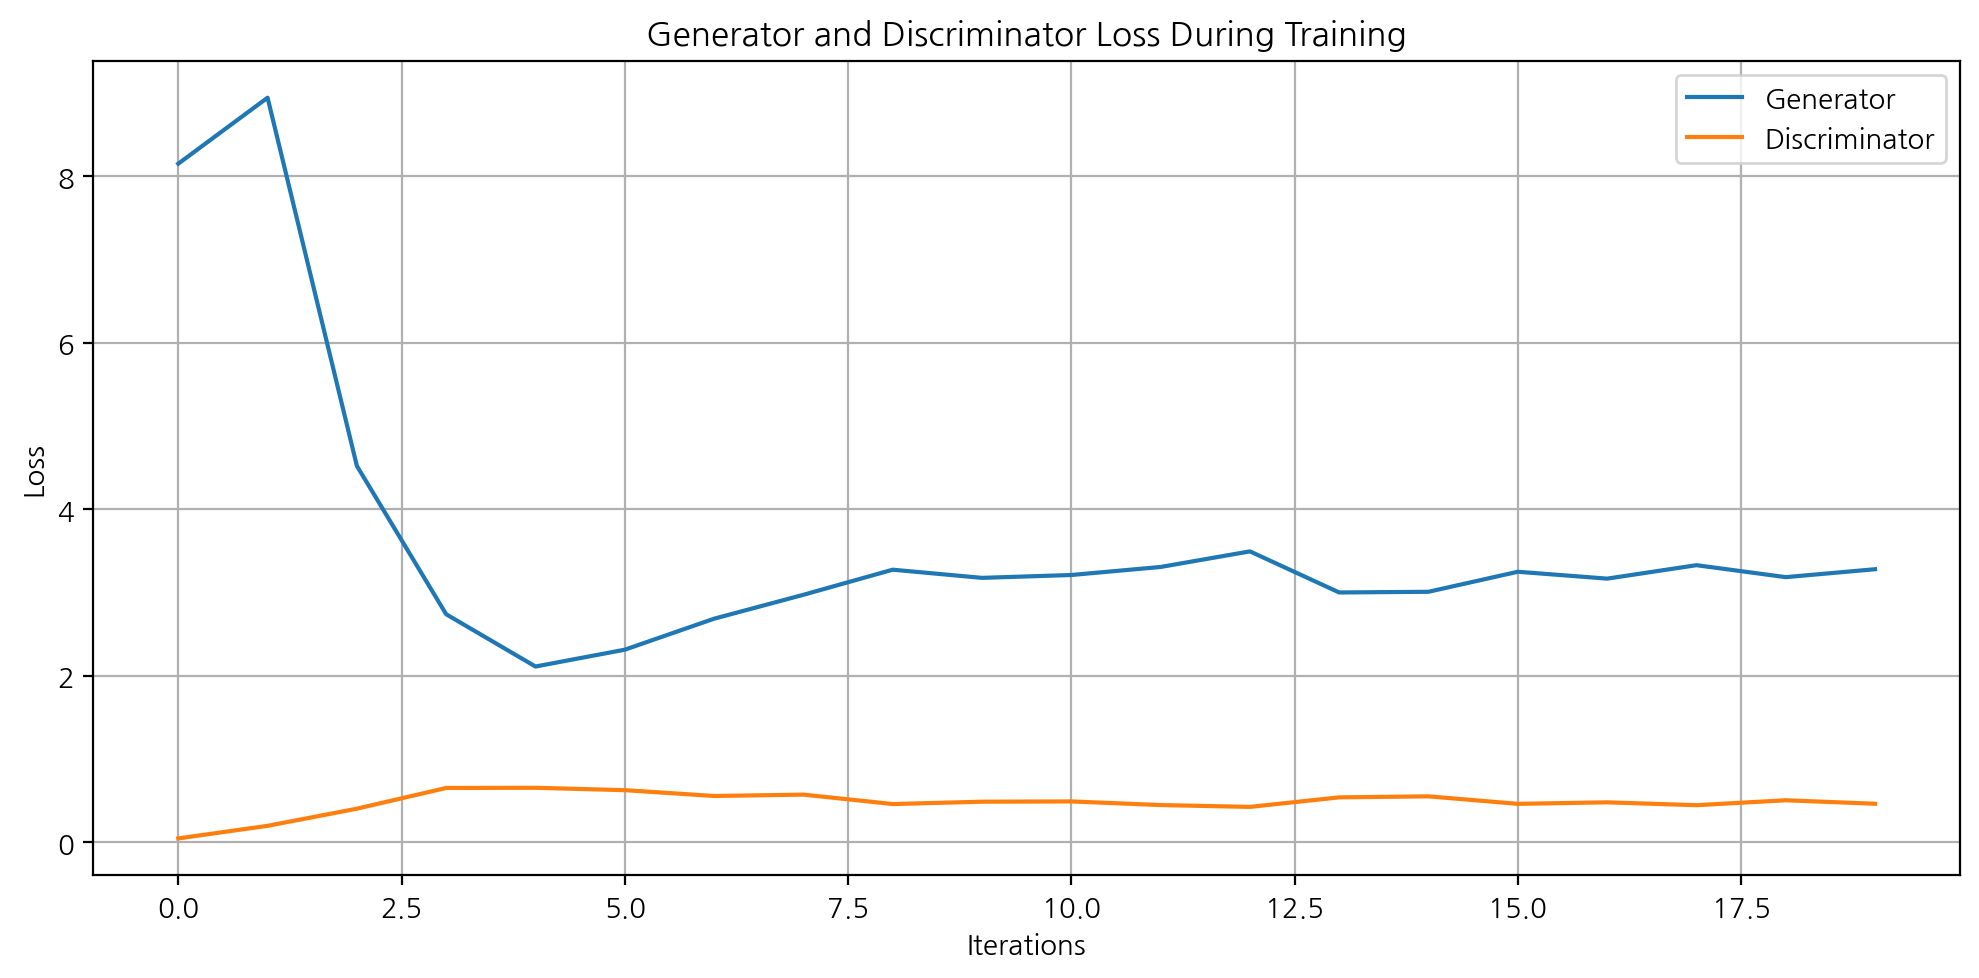

In [ ]:
# (11) 학습 후 손실 시각화
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

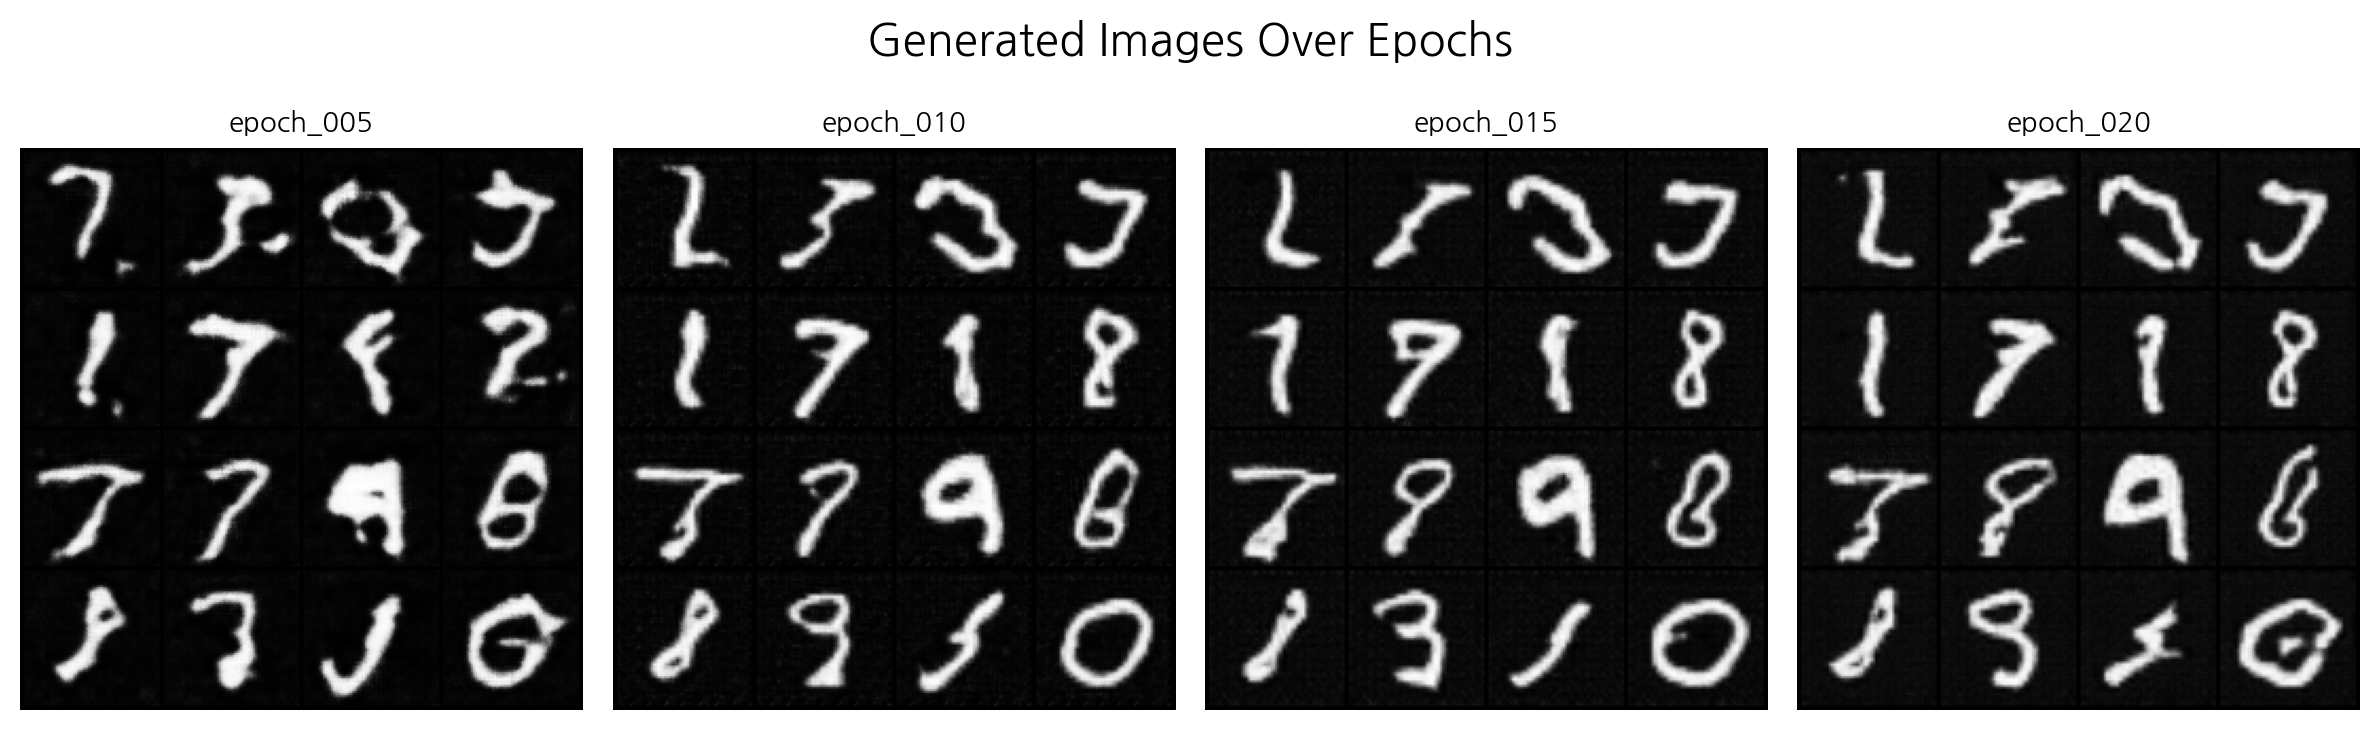

In [ ]:
# (12) 에폭별 생성 이미지 시각화
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

# 저장 폴더 지정
image_dir = './gen_images'

# PNG 이미지 파일 경로 가져오기
image_paths = sorted(glob.glob(os.path.join(image_dir, 'epoch_*.png')))

# 이미지 개수와 subplot 행렬 구성
num_images = len(image_paths)
cols = 4
rows = (num_images + cols - 1) // cols

# subplot 설정
plt.figure(figsize=(cols * 3, rows * 4))
for idx, path in enumerate(image_paths):
    img = mpimg.imread(path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(path).replace('.png', ''), fontsize=10)
    plt.axis('off')

# 레이아웃 조정 및 제목 위치 이동
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # 상단 여백 확보
plt.suptitle("Generated Images Over Epochs", fontsize=16)
plt.show()

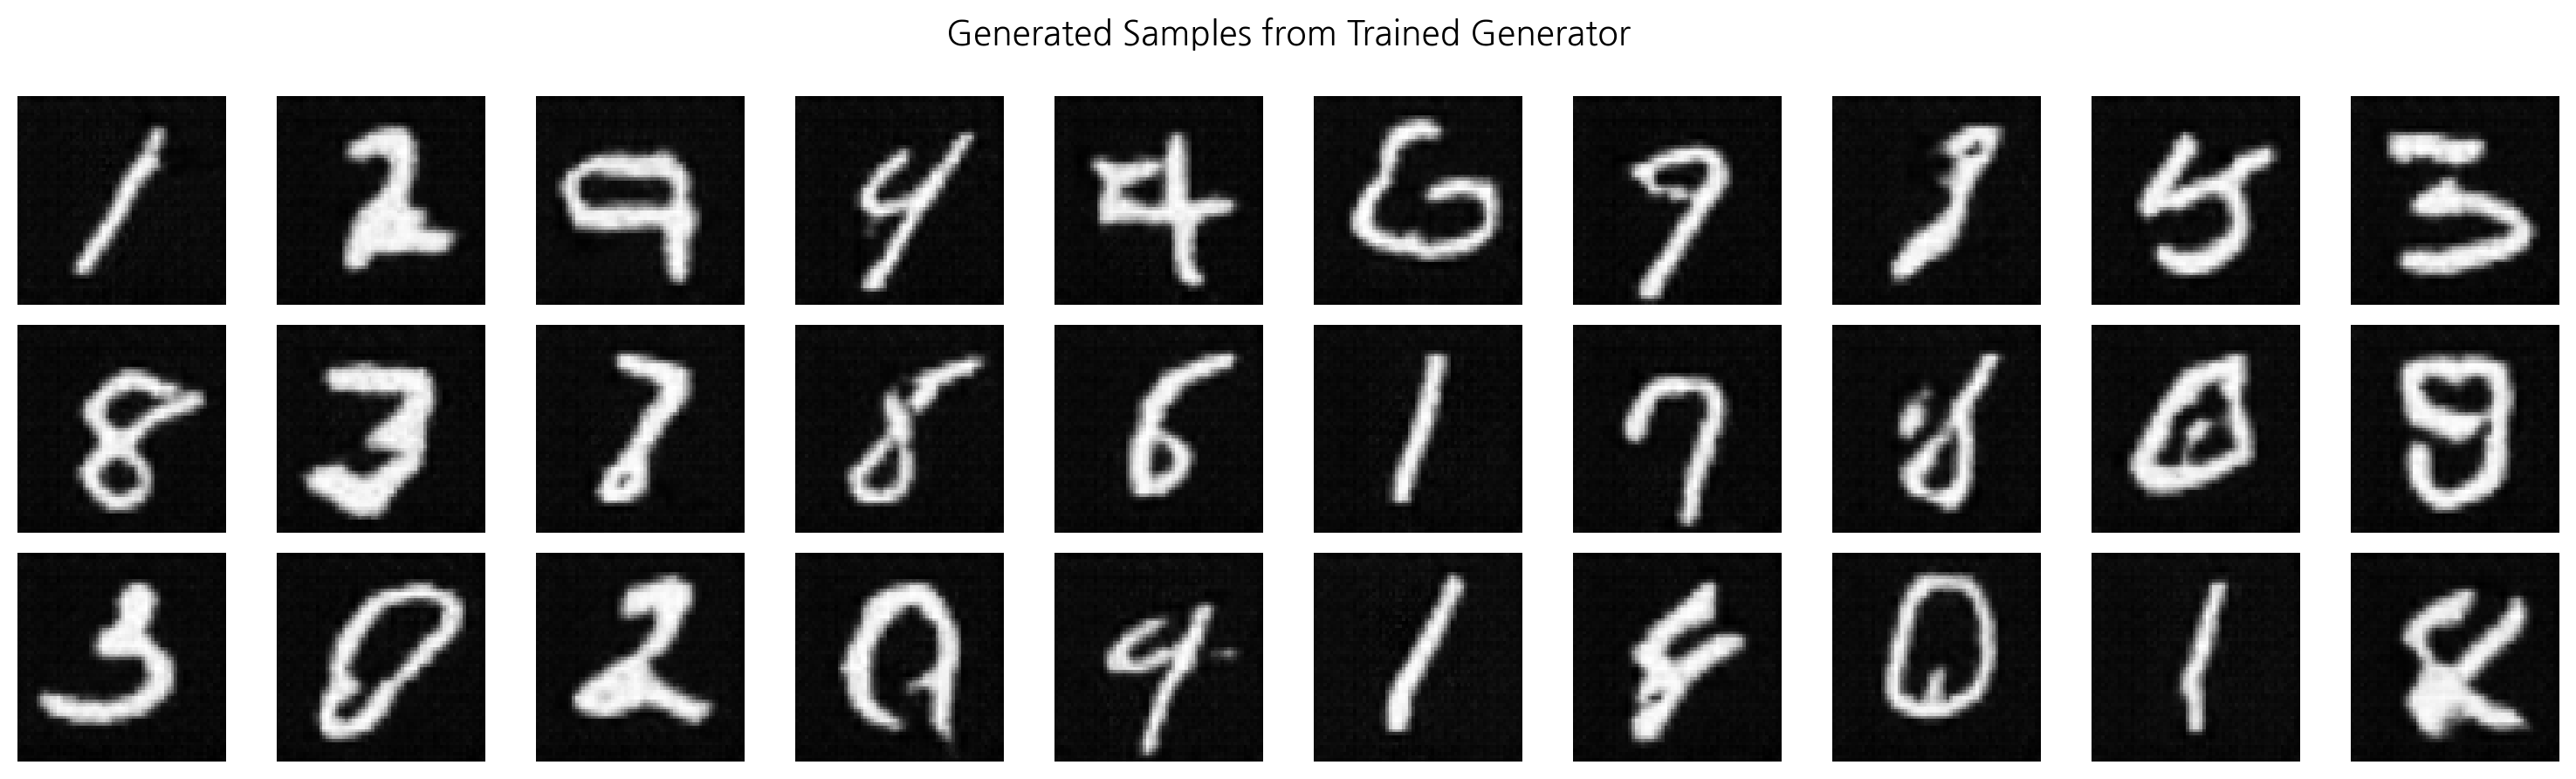

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# (12) 훈련된 Generator로부터 30개 샘플 생성 및 시각화

# 생성할 샘플 수
num_samples = 30
rows = 3
cols = 10

# latent vector z 생성 (랜덤 잡음)
noise = torch.randn(num_samples, nz, 1, 1, device=device)

# Generator로부터 가짜 이미지 생성
with torch.no_grad():
    fake_images = netG(noise).detach().cpu()

# 정규화된 이미지 [-1, 1] → [0, 1]로 다시 변환
fake_images = (fake_images + 1) / 2

# 시각화
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(fake_images[idx][0], cmap='gray')  # 흑백 이미지이므로 [0] 채널만
    ax.axis('off')

plt.suptitle("Generated Samples from Trained Generator", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # 제목 여백
plt.show()


## 종료